In [1]:
from pyspark.sql import SparkSession
import time

# A simpler SparkSession configuration
spark = SparkSession.builder \
    .appName("new Simple Sentiment Analysis") \
    .config("spark.executor.memory", "4g") \
    .config("spark.driver.memory", "4g") \
    .config("spark.sql.shuffle.partitions", "6") \
    .config("spark.sql.adaptive.enabled", "true") \
    .getOrCreate()

try:
    print("1. Reading data...")
    file_path = "hdfs:///user/bda/processed_data"
    data = spark.read.parquet(file_path)
    print("Data reading completed.")

    print("\n2. Data size:")
    total_count = data.count()
    print(f"Total number of records: {total_count}")

    print("\n3. Adding sentiment labels...")
    from pyspark.sql.functions import col, when
    data = data.withColumn(
        "sentiment",
        when(col("rating") >= 4, "positive")
        .when(col("rating") <= 2, "negative")
        .otherwise("neutral")
    )
    
    # Filtering out neutral sentiments
    data = data.filter(col("sentiment") != "neutral")
    
    print("\n4. Class distribution:")
    class_counts = data.groupBy("sentiment").count()
    class_counts.show()
    
    print("\n5. Sampling data...")
    # Take a smaller sample
    #sampled_data = data.sample(fraction=0.5, seed=42)  # Only 50%
    train_data, test_data = data.randomSplit([0.8, 0.2], seed=42)
    
    train_count = train_data.count()
    test_count = test_data.count()
    print(f"Training set size: {train_count}")
    print(f"Test set size: {test_count}")
    
    if train_count > 0 and test_count > 0:
        print("\n6. Training the model...")
        from pyspark.ml.feature import CountVectorizer, StringIndexer
        from pyspark.ml import Pipeline
        from pyspark.ml.classification import LogisticRegression
        
        # Pipeline components
        vectorizer = CountVectorizer(inputCol="filtered_words", 
                                     outputCol="features",
                                     minDF=1.0,
                                     vocabSize=10000)  # Limit vocabulary size
        
        indexer = StringIndexer(inputCol="sentiment", 
                                outputCol="sentiment_index")
        
        lr = LogisticRegression(featuresCol="features", 
                                 labelCol="sentiment_index",
                                 maxIter=3)  # Reduce the number of iterations
        
        # Build and train the pipeline
        pipeline = Pipeline(stages=[vectorizer, indexer, lr])
        
        print("Training the model...")
        pipeline_model = pipeline.fit(train_data)
        
        print("\n7. Making predictions...")
        predictions = pipeline_model.transform(test_data)
        
        print("\n8. Evaluating the model:")
        from pyspark.ml.evaluation import MulticlassClassificationEvaluator
        evaluator = MulticlassClassificationEvaluator(
            labelCol="sentiment_index", 
            predictionCol="prediction"
        )
        
        accuracy = evaluator.setMetricName("accuracy").evaluate(predictions)
        print(f"Accuracy: {accuracy:.2f}")
        
        print("\n9. Process completed successfully!")
    
except Exception as e:
    print(f"\nAn error occurred: {str(e)}")
    print("Error details:", e.__class__.__name__)

finally:
    print("Process terminated.")


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/01/19 15:57:40 INFO SparkEnv: Registering MapOutputTracker
25/01/19 15:57:40 INFO SparkEnv: Registering BlockManagerMaster
25/01/19 15:57:40 INFO SparkEnv: Registering BlockManagerMasterHeartbeat
25/01/19 15:57:41 INFO SparkEnv: Registering OutputCommitCoordinator


1. Reading data...


Data reading completed.

2. Data size:


Total number of records: 23911390

3. Adding sentiment labels...

4. Class distribution:


+---------+--------+
|sentiment|   count|
+---------+--------+
| negative| 4115909|
| positive|18079660|
+---------+--------+


5. Sampling data...


Training set size: 17754297
Test set size: 4441272

6. Training the model...
Training the model...



7. Making predictions...

8. Evaluating the model:


Accuracy: 0.91

9. Process completed successfully!
Process terminated.


In [ ]:
#pipeline_model.write().overwrite().save("hdfs:///user/bda/sentiment_model")

In [2]:
evaluator.setMetricName("f1")
f1_score = evaluator.evaluate(predictions)
print(f"F1 Score: {f1_score:.2f}")

evaluator = MulticlassClassificationEvaluator(labelCol="sentiment_index", predictionCol="prediction")
precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})

print(f"Precision: {precision:.2f}, Recall: {recall:.2f}")

F1 Score: 0.91


Precision: 0.90, Recall: 0.91


In [3]:
from pyspark.sql import functions as F

confusion_matrix = predictions.groupBy("sentiment_index", "prediction").count()
confusion_matrix.show()


+---------------+----------+-------+
|sentiment_index|prediction|  count|
+---------------+----------+-------+
|            1.0|       0.0| 276517|
|            1.0|       1.0| 545805|
|            0.0|       0.0|3490207|
|            0.0|       1.0| 128743|
+---------------+----------+-------+



In [4]:
#Logistic Regression Feature Importance

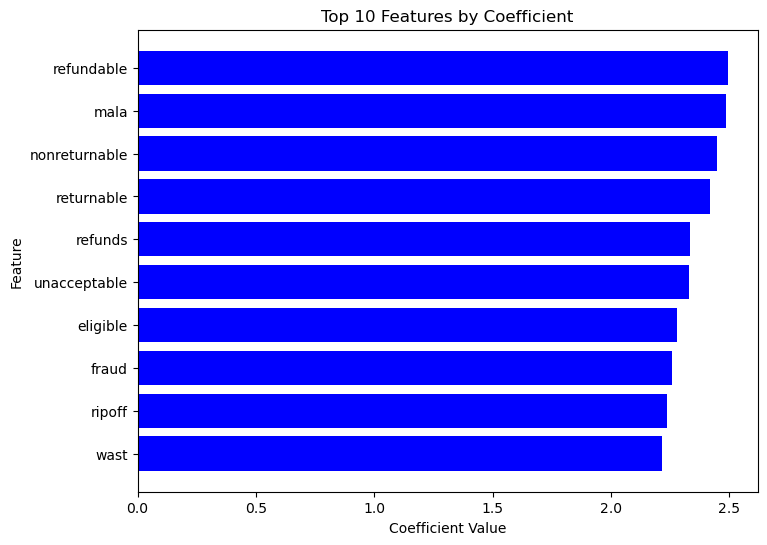

In [5]:
# Get the CountVectorizerModel from the pipeline
vectorizer_model = pipeline_model.stages[0]  # CountVectorizer is the first stage
vocabulary = vectorizer_model.vocabulary

# Get the LogisticRegressionModel from the pipeline
lr_model = pipeline_model.stages[-1]  # Logistic Regression is the last stage
coefficients = lr_model.coefficients.toArray()

# Combine features and coefficients
import pandas as pd
import matplotlib.pyplot as plt

feature_importance = pd.DataFrame({"Feature": vocabulary, "Coefficient": coefficients})
feature_importance = feature_importance.sort_values(by="Coefficient", ascending=False)

# Plot top 10 features
top_features = feature_importance.head(10)
plt.figure(figsize=(8, 6))
plt.barh(top_features["Feature"], top_features["Coefficient"], color="blue")
plt.title("Top 10 Features by Coefficient")
plt.xlabel("Coefficient Value")
plt.ylabel("Feature")
plt.gca().invert_yaxis()  # Flip the Y-axis for better readability
plt.show()


In [10]:
# Display predictions
predictions.select("filtered_words","rating", "sentiment_index", "prediction").show(5, truncate=True)

+--------------------+------+---------------+----------+
|      filtered_words|rating|sentiment_index|prediction|
+--------------------+------+---------------+----------+
|[2d, time, purcha...|   4.0|            0.0|       0.0|
|[12, always, aski...|   5.0|            0.0|       0.0|
|[super, fun, make...|   4.0|            0.0|       0.0|
|[bit, dated, days...|   4.0|            0.0|       0.0|
|[lighted, mirror,...|   5.0|            0.0|       0.0|
+--------------------+------+---------------+----------+
only showing top 5 rows



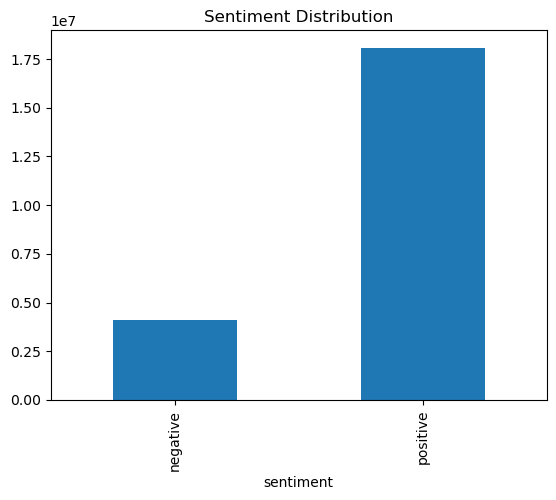

In [7]:
import matplotlib.pyplot as plt

# Convert to Pandas for visualization
sentiment_counts = data.groupBy("sentiment").count().toPandas()
sentiment_counts.plot(kind="bar", x="sentiment", y="count", legend=False)
plt.title("Sentiment Distribution")
plt.show()

In [8]:
#Are there ambiguous reviews (e.g., sarcasm)?
predictions.filter(col("sentiment_index") != col("prediction")).select("filtered_words", "sentiment_index", "prediction").show(5, truncate=False)


+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------------+----------+
|filtered_words                                                                                                                                                                                                                                                                               |sentiment_index|prediction|
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------------+----------+
|[people, unhappy, strong, enough, edt, eau, de, toilet

In [3]:
predictions.printSchema()


root
 |-- asin: string (nullable = true)
 |-- helpful_vote: long (nullable = true)
 |-- images: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- attachment_type: string (nullable = true)
 |    |    |-- large_image_url: string (nullable = true)
 |    |    |-- medium_image_url: string (nullable = true)
 |    |    |-- small_image_url: string (nullable = true)
 |-- parent_asin: string (nullable = true)
 |-- rating: double (nullable = true)
 |-- text: string (nullable = true)
 |-- timestamp: long (nullable = true)
 |-- title: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- verified_purchase: boolean (nullable = true)
 |-- cleaned_text: string (nullable = true)
 |-- words: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- filtered_words: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- sentiment: string (nullable = false)
 |-- features: vector (nullable = true)
 |-- sentiment_ind

In [2]:
data.printSchema()


root
 |-- asin: string (nullable = true)
 |-- helpful_vote: long (nullable = true)
 |-- images: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- attachment_type: string (nullable = true)
 |    |    |-- large_image_url: string (nullable = true)
 |    |    |-- medium_image_url: string (nullable = true)
 |    |    |-- small_image_url: string (nullable = true)
 |-- parent_asin: string (nullable = true)
 |-- rating: double (nullable = true)
 |-- text: string (nullable = true)
 |-- timestamp: long (nullable = true)
 |-- title: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- verified_purchase: boolean (nullable = true)
 |-- cleaned_text: string (nullable = true)
 |-- words: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- filtered_words: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- sentiment: string (nullable = false)



In [10]:
from pyspark.sql.functions import col, from_unixtime, year, month, avg, count, when

# Milisaniyeden saniyeye dönüştürme
predictions = predictions.withColumn("timestamp", (col("timestamp") / 1000).cast("long"))

# `review_date` kolonunu oluşturma
predictions = predictions.withColumn("review_date", from_unixtime("timestamp").cast("date"))

# Temporal Analysis
temporal_trends = predictions.groupBy(
    year("review_date").alias("year"),
    month("review_date").alias("month")
).agg(
    avg(when(col("prediction") == 1.0, 1).otherwise(0)).alias("positive_ratio"),
    count("*").alias("review_count"),
    avg("rating").alias("avg_rating"),
    avg(when(col("verified_purchase") == True, 1).otherwise(0)).alias("verified_ratio")
).orderBy("year", "month")

# Sonuçları gösterme
temporal_trends.show()




+----+-----+-------------------+------------+------------------+-------------------+
|year|month|     positive_ratio|review_count|        avg_rating|     verified_ratio|
+----+-----+-------------------+------------+------------------+-------------------+
|2000|    6|                0.0|           1|               5.0|                0.0|
|2000|   11|                0.5|           2|               4.5|                0.0|
|2001|    4|                0.0|           2|               5.0|                0.0|
|2001|    6|                1.0|           1|               1.0|                1.0|
|2001|    8|                0.0|           2|               3.5|                0.0|
|2001|    9|                0.0|           1|               5.0|                0.0|
|2001|   10|                0.0|           1|               5.0|                1.0|
|2001|   12|                0.0|           1|               5.0|                0.0|
|2002|    1|                0.0|           1|               5.0| 

In [9]:
predictions.select("review_date").show(5, truncate=False)


+-------------+
|timestamp    |
+-------------+
|1493602642000|
|1559066596402|
|1583757076398|
|1492538894000|
|1465929881000|
+-------------+
only showing top 5 rows



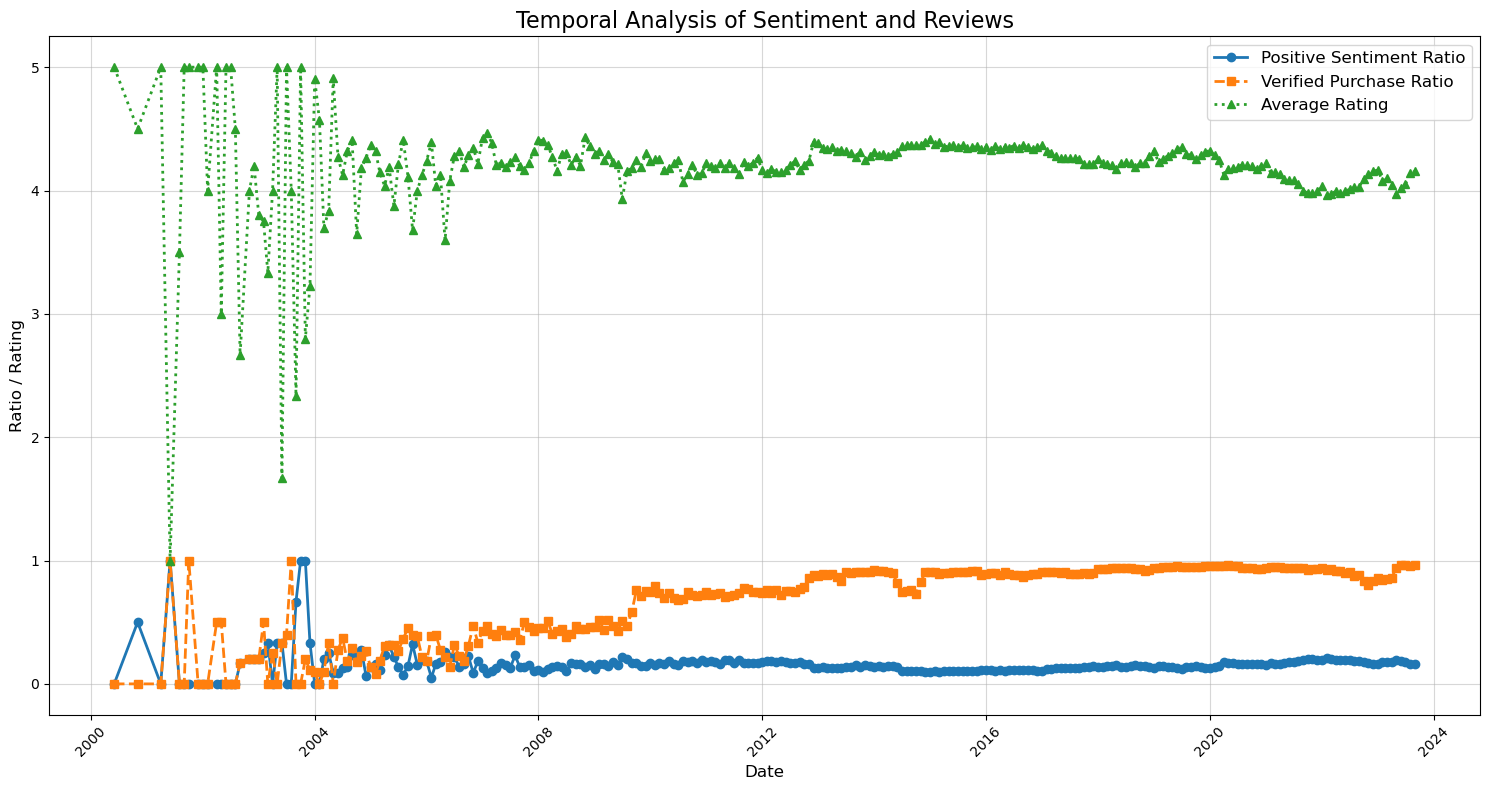

In [11]:
import matplotlib.pyplot as plt
import pandas as pd

# Temporal Trends'i Pandas DataFrame'e dönüştürme
temporal_trends_pd = temporal_trends.toPandas()

# Yıl ve Ay kolonlarını birleştirerek bir tarih kolonu oluşturma
temporal_trends_pd['date'] = pd.to_datetime(
    temporal_trends_pd[['year', 'month']].assign(day=1)
)

# Görselleştirme
plt.figure(figsize=(15, 8))

# Pozitif oran trendi
plt.plot(
    temporal_trends_pd['date'], temporal_trends_pd['positive_ratio'], 
    label='Positive Sentiment Ratio', linewidth=2, marker='o'
)

# Doğrulanmış satın alma oranı
plt.plot(
    temporal_trends_pd['date'], temporal_trends_pd['verified_ratio'], 
    label='Verified Purchase Ratio', linewidth=2, marker='s', linestyle='--'
)

# Ortalama puan trendi
plt.plot(
    temporal_trends_pd['date'], temporal_trends_pd['avg_rating'], 
    label='Average Rating', linewidth=2, marker='^', linestyle=':'
)

# Grafiği kişiselleştirme
plt.title('Temporal Analysis of Sentiment and Reviews', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Ratio / Rating', fontsize=12)
plt.legend(fontsize=12)
plt.grid(alpha=0.5)
plt.xticks(fontsize=10, rotation=45)
plt.yticks(fontsize=10)
plt.tight_layout()

# Grafiği gösterme
plt.show()

    

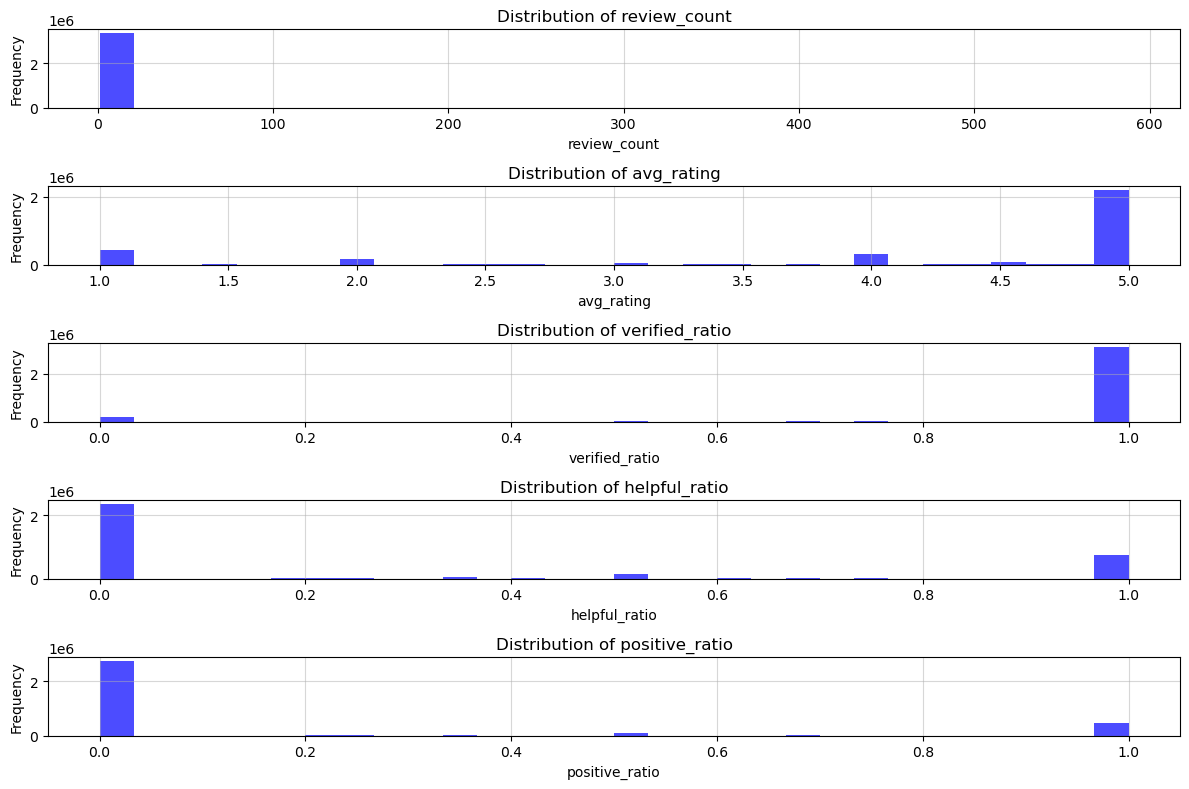

In [6]:
import matplotlib.pyplot as plt

# Her metrik için ayrı bir grafik oluşturma
metrics = ['review_count', 'avg_rating', 'verified_ratio', 'helpful_ratio', 'positive_ratio']

plt.figure(figsize=(12, 8))  # Ana grafik boyutu
for i, metric in enumerate(metrics):
    # Her bir metriği ayrı bir subplot olarak çiz
    plt.subplot(len(metrics), 1, i + 1)
    plt.hist(customer_segments_pd[metric], bins=30, alpha=0.7, color='blue')
    plt.title(f'Distribution of {metric}', fontsize=12)  # Başlık
    plt.xlabel(metric, fontsize=10)  # X ekseni etiketi
    plt.ylabel('Frequency', fontsize=10)  # Y ekseni etiketi
    plt.grid(alpha=0.5)  # Izgara çizgileri

plt.tight_layout()  # Grafiklerin üst üste binmesini önler
plt.show()  # Grafikleri göster


In [ ]:
#spark.stop()
